<a href="https://colab.research.google.com/github/Arifullah007/DopaVox/blob/main/evaluation_and_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:

# ---------------------------
# STEP 1: Generalization + Bootstrap Evaluation
# ---------------------------
# Paste this into a new code cell in your evaluation notebook.

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.utils import resample
from pprint import pprint

RANDOM_STATE = 42
N_SPLITS = 5
N_BOOT = 500   # bootstrap samples for confidence intervals (increase if you have CPU/time)

# --- 1) Load dataset (same file you trained the model with)
DATA_PATH = "parkinsons.data"   # change this path if your file name differs
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH} — upload it to the workspace or change DATA_PATH.")

df = pd.read_csv(DATA_PATH)

# Drop any non-numeric columns except the target 'status' (commonly 'name' is present)
non_numeric = [c for c in df.columns if df[c].dtype == 'object' and c != 'status']
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)
    df = df.drop(columns=non_numeric)

# Prepare features and target
if 'status' not in df.columns:
    raise ValueError("Target column 'status' not found in dataset. Ensure your dataset uses column name 'status'.")
X_all = df.drop(columns=['status']).astype(float).values
y_all = df['status'].astype(int).values

print("Data shapes:", X_all.shape, y_all.shape)
print("Class distribution:", np.unique(y_all, return_counts=True))

# --- 2) Load model or pipeline
MODEL_CANDIDATES = ["pipeline.pkl", "parkinsons_model.pkl", "parkisons_model.pkl"]
loaded = None
for fname in MODEL_CANDIDATES:
    if os.path.exists(fname):
        loaded = joblib.load(fname)
        print(f"Loaded model from: {fname}")
        break
if loaded is None:
    raise FileNotFoundError("No pipeline/model found. Upload 'pipeline.pkl' or 'parkinsons_model.pkl' to the workspace.")

# We'll call it `pipe` and (re)fit inside CV folds to measure generalization.
pipe = loaded

# --- 3) Stratified K-Fold CV
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
fold_metrics = []

print("\nRunning Stratified K-Fold CV ...")
for fold_idx, (tr_idx, te_idx) in enumerate(skf.split(X_all, y_all), start=1):
    X_tr, y_tr = X_all[tr_idx], y_all[tr_idx]
    X_te, y_te = X_all[te_idx], y_all[te_idx]

    # Fit (if pipe is a fitted estimator this will overwrite — that's fine for measuring fold performance)
    try:
        pipe.fit(X_tr, y_tr)
    except Exception as e:
        # If pipe expects different input (like DataFrame), try converting back to DataFrame
        try:
            X_tr_df = pd.DataFrame(X_tr, columns=df.drop(columns=['status']).columns)
            X_te_df = pd.DataFrame(X_te, columns=df.drop(columns=['status']).columns)
            pipe.fit(X_tr_df, y_tr)
            probs = pipe.predict_proba(X_te_df)[:, 1]
        except Exception as e2:
            raise RuntimeError("Fitting the loaded model/pipeline failed inside CV. See original error.") from e

    # Predict probabilities on test fold
    probs = pipe.predict_proba(X_te)[:, 1]
    pred = (probs >= 0.5).astype(int)

    roc = roc_auc_score(y_te, probs)
    pr = average_precision_score(y_te, probs)   # area under PR curve (average precision)
    bal = balanced_accuracy_score(y_te, pred)

    fold_metrics.append({"fold": fold_idx, "ROC_AUC": roc, "PR_AUC": pr, "BalAcc": bal})
    print(f"Fold {fold_idx} -> ROC_AUC: {roc:.4f}, PR_AUC: {pr:.4f}, BalAcc: {bal:.4f}")

# Summary stats across folds
df_folds = pd.DataFrame(fold_metrics).set_index("fold")
summary = df_folds.agg(['mean','std']).T
print("\nCross-Validation results (mean ± std):")
print(summary[['mean','std']].rename(columns={'mean':'mean','std':'std'}))

# --- 4) Bootstrap confidence intervals (on the whole dataset predictions by retraining on each bootstrap sample)
# We'll do bootstrap by resampling the dataset with replacement, fitting the pipeline, predicting on the *out-of-bag* samples,
# and collecting metrics. This approximates performance variability.

print("\nRunning bootstrap (this may take a while):")
roc_samples, pr_samples, bal_samples = [], [], []
n = X_all.shape[0]
rng = np.random.RandomState(RANDOM_STATE)

for i in range(N_BOOT):
    # sample indices with replacement
    idx_boot = rng.randint(0, n, n)
    idx_oob = np.setdiff1d(np.arange(n), np.unique(idx_boot))  # out-of-bag indices

    # If there are no OOB samples (rare for small n), skip this bootstrap iteration
    if idx_oob.size == 0:
        continue

    Xb, yb = X_all[idx_boot], y_all[idx_boot]
    X_oob, y_oob = X_all[idx_oob], y_all[idx_oob]

    try:
        pipe.fit(Xb, yb)
        probs_oob = pipe.predict_proba(X_oob)[:, 1]
        pred_oob = (probs_oob >= 0.5).astype(int)

        roc_samples.append(roc_auc_score(y_oob, probs_oob))
        pr_samples.append(average_precision_score(y_oob, probs_oob))
        bal_samples.append(balanced_accuracy_score(y_oob, pred_oob))
    except Exception:
        # If a particular bootstrap iteration fails, skip it
        continue

# Compute 95% CI (percentile)
def ci_percentile(samples, alpha=0.05):
    arr = np.array(samples)
    lower = np.percentile(arr, 100 * (alpha/2))
    upper = np.percentile(arr, 100 * (1 - alpha/2))
    return lower, upper

roc_ci = ci_percentile(roc_samples)
pr_ci = ci_percentile(pr_samples)
bal_ci = ci_percentile(bal_samples)

print("\nBootstrap 95% CIs:")
print(f"ROC AUC: {roc_ci[0]:.4f} — {roc_ci[1]:.4f} (n={len(roc_samples)} samples)")
print(f"PR AUC:  {pr_ci[0]:.4f} — {pr_ci[1]:.4f} (n={len(pr_samples)} samples)")
print(f"BalAcc:  {bal_ci[0]:.4f} — {bal_ci[1]:.4f} (n={len(bal_samples)} samples)")

# Save results CSV for record
out_df = pd.DataFrame({
    "fold_ROC": df_folds["ROC_AUC"].tolist(),
    "fold_PR": df_folds["PR_AUC"].tolist(),
    "fold_BalAcc": df_folds["BalAcc"].tolist()
})
out_df.to_csv("cv_fold_metrics.csv", index=False)
print("\nSaved fold metrics to cv_fold_metrics.csv")

# also save bootstrap samples if you want
pd.DataFrame({"roc": roc_samples, "pr": pr_samples, "bal": bal_samples}).to_csv("bootstrap_samples.csv", index=False)
print("Saved bootstrap samples to bootstrap_samples.csv")

# Quick summary object to inspect in the notebook
results = {
    "cv_summary": summary,
    "bootstrap_cis": {"roc": roc_ci, "pr": pr_ci, "bal": bal_ci},
    "n_boot": len(roc_samples)
}
pprint(results)


Dropping non-numeric columns: ['name']
Data shapes: (195, 22) (195,)
Class distribution: (array([0, 1]), array([ 48, 147]))
Loaded model from: parkinsons_model.pkl

Running Stratified K-Fold CV ...
Fold 1 -> ROC_AUC: 0.9630, PR_AUC: 0.9873, BalAcc: 0.9444
Fold 2 -> ROC_AUC: 0.9667, PR_AUC: 0.9888, BalAcc: 0.9278
Fold 3 -> ROC_AUC: 0.9914, PR_AUC: 0.9966, BalAcc: 0.9155
Fold 4 -> ROC_AUC: 0.9759, PR_AUC: 0.9905, BalAcc: 0.6500
Fold 5 -> ROC_AUC: 0.8690, PR_AUC: 0.9518, BalAcc: 0.6655

Cross-Validation results (mean ± std):
             mean       std
ROC_AUC  0.953167  0.048330
PR_AUC   0.982995  0.017792
BalAcc   0.820651  0.149155

Running bootstrap (this may take a while):

Bootstrap 95% CIs:
ROC AUC: 0.8770 — 0.9917 (n=500 samples)
PR AUC:  0.9511 — 0.9975 (n=500 samples)
BalAcc:  0.7112 — 0.9327 (n=500 samples)

Saved fold metrics to cv_fold_metrics.csv
Saved bootstrap samples to bootstrap_samples.csv
{'bootstrap_cis': {'bal': (np.float64(0.7112398227969349),
                      

Dropping non-numeric columns: ['name']
Brier Score (lower = better calibration): 0.0610
ROC AUC (check consistency): 0.9820


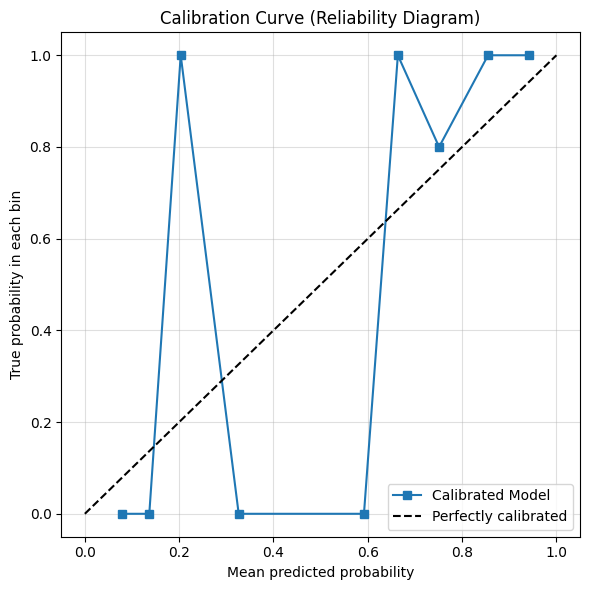

✅ Saved calibrated model as pipeline_calibrated.pkl


In [9]:
# STEP 2: Model Calibration and Reliability Metrics
# --------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split

# 1️⃣ Load your dataset again
df = pd.read_csv("parkinsons.data")

# Drop any non-numeric columns except 'status'
non_numeric = [c for c in df.columns if df[c].dtype == 'object' and c != 'status']
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)
    df = df.drop(columns=non_numeric)

X = df.drop(columns=['status']).astype(float)
y = df['status'].astype(int)

# 2️⃣ Load your trained model
model = joblib.load("parkinsons_model.pkl")  # or pipeline.pkl if you used pipeline

# 3️⃣ Split into calibration and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4️⃣ Fit a calibrated version using sigmoid method (Platt scaling)
calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv=5)
calibrated_model.fit(X_train, y_train)

# 5️⃣ Predict probabilities and evaluate reliability
probs = calibrated_model.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, probs)
roc = roc_auc_score(y_test, probs)

print(f"Brier Score (lower = better calibration): {brier:.4f}")
print(f"ROC AUC (check consistency): {roc:.4f}")

# 6️⃣ Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="Calibrated Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("True probability in each bin")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("calibration_curve.png", dpi=200)
plt.show()

# 7️⃣ Save the calibrated model
joblib.dump(calibrated_model, "pipeline_calibrated.pkl")
print("✅ Saved calibrated model as pipeline_calibrated.pkl")


In [10]:
# ----------------------------
# STEP 3: Explainability (SHAP) + Ablation study
# ----------------------------
# Paste this into a new code cell in your evaluation notebook.

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import shap
import warnings
warnings.filterwarnings("ignore")

# ------- SETTINGS -------
DATA_PATH = "parkinsons.data"          # dataset used for training
PIPELINE_FILES = ["pipeline_calibrated.pkl", "pipeline.pkl", "parkinsons_model.pkl"]
OUTPUT_DIR = "explainability_outputs"
RANDOM_STATE = 42
TEST_SIZE = 0.2
# ------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) load dataset
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH} — upload it or change DATA_PATH.")
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)

# drop obvious non-numeric columns except target 'status'
non_numeric = [c for c in df.columns if df[c].dtype == "object" and c != "status"]
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)
    df = df.drop(columns=non_numeric)

if 'status' not in df.columns:
    raise ValueError("Target column 'status' not found. Ensure your dataset uses 'status' as label.")

# Split features / label
X_all = df.drop(columns=['status']).astype(float)
y_all = df['status'].astype(int)

# 2) Load model / pipeline
pipeline = None
for fn in PIPELINE_FILES:
    if os.path.exists(fn):
        pipeline = joblib.load(fn)
        print("Loaded model from:", fn)
        break
if pipeline is None:
    raise FileNotFoundError(f"No pipeline file found. Expected one of: {PIPELINE_FILES}")

# If pipeline is a full sklearn pipeline, we will use pipeline.predict_proba(X)
# For SHAP, we need a function that maps X -> model output probabilities or raw predictions.
def predict_proba_from_pipeline(X):
    """Return the positive-class probability vector for X (numpy array)."""
    try:
        proba = pipeline.predict_proba(X)
        # ensure shape (n_samples, n_classes)
        if proba.ndim == 1:
            # some models return single-col probabilities — treat as positive class
            proba = np.vstack([1 - proba, proba]).T
        return proba
    except Exception as e:
        # pipeline may be a model requiring preprocessing — try transform then estimator
        # fallback: run pipeline(X) and try to interpret
        preds = pipeline.predict(X)
        # convert to prob-like (0/1 => [1,0] or [0,1])
        prob_pos = np.asarray(preds).astype(float)
        prob_pos = prob_pos.reshape(-1, 1)
        proba = np.hstack([1 - prob_pos, prob_pos])
        return proba

# 3) Train/test split for explainability evaluation (we don't retrain model here)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all)
print("Train/test shapes:", X_train.shape, X_test.shape)

# 4) Compute baseline metrics on test set
proba_test = predict_proba_from_pipeline(X_test)
# assume positive class is index 1
if proba_test.shape[1] == 1:
    pos_probs = proba_test.ravel()
else:
    pos_probs = proba_test[:, 1]
roc = roc_auc_score(y_test, pos_probs)
bal_acc = balanced_accuracy_score(y_test, (pos_probs >= 0.5).astype(int))
print(f"Test ROC AUC: {roc:.4f}   Balanced Acc: {bal_acc:.4f}")

# 5) SHAP explainability
# We'll try shap.Explainer (auto) first; fallback to TreeExplainer if needed.
explainer = None
shap_values = None

print("\nCreating SHAP explainer (this may take a moment)...")
try:
    # Use a small background sample to speed up explanation
    background = X_train.sample(min(len(X_train), 100), random_state=RANDOM_STATE)
    # shap.Explainer can wrap pipeline.predict_proba or pipeline itself. We'll create a wrapper that returns positive class probability.
    def model_prob_wrapper(X_df):
        # Accepts numpy array or pandas DataFrame => return pos class prob vector
        if isinstance(X_df, np.ndarray):
            X_tmp = pd.DataFrame(X_df, columns=X_train.columns)
        else:
            X_tmp = X_df
        p = predict_proba_from_pipeline(X_tmp)
        # shap expects shape (n, ) or (n, outputs) depending; we return the single positive-class prob
        return p[:, 1]
    # Try the new API
    explainer = shap.Explainer(model_prob_wrapper, background, output_names=["prob_pos"])
    shap_values = explainer(X_test)
    print("SHAP explainer created with shap.Explainer.")
except Exception as e:
    print("shap.Explainer failed, falling back to TreeExplainer / KernelExplainer. Error:", e)
    try:
        # if pipeline has internal estimator attribute (like pipeline.named_steps['clf'])
        estimator = None
        if hasattr(pipeline, "named_steps"):
            # heuristics: last step is often the estimator
            estimator = list(pipeline.named_steps.values())[-1]
        else:
            estimator = pipeline
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_test)
        print("Used TreeExplainer (fast for tree-based models).")
    except Exception as e2:
        print("TreeExplainer failed. Trying KernelExplainer (slower). Error:", e2)
        # kernel explainer needs callable returning model prob and a background array
        import time
        start = time.time()
        explainer = shap.KernelExplainer(model_prob_wrapper, background)
        shap_values = explainer.shap_values(X_test[:100])  # limit for speed
        print("Used KernelExplainer (slower). Took", time.time()-start, "s")

# 6) Convert SHAP outputs to convenient DataFrame (handles both new and old shap outputs)
# If shap_values is shap.Explanation object:
if hasattr(shap_values, "values"):
    # shap.Explanation: values shape (n_samples, n_features) for single-output explainers
    sv = np.array(shap_values.values)
else:
    # older format shap_values could be list (for classifiers with per-class shap)
    try:
        sv = np.array(shap_values)  # may be (n_classes, n_samples, n_features)
        if sv.ndim == 3:
            # try to pick class-1 explanations if exists (common layout)
            sv = sv[1]
    except Exception:
        raise RuntimeError("Could not interpret shap_values format.")

# sv shape -> (n_samples, n_features)
print("SHAP values shape:", sv.shape)
feature_names = X_test.columns.tolist()

# mean absolute SHAP per feature
mean_abs_shap = np.mean(np.abs(sv), axis=0)
shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)
shap_df.to_csv(os.path.join(OUTPUT_DIR, "shap_mean_abs.csv"), index=False)
print("Saved mean |SHAP| per feature ->", os.path.join(OUTPUT_DIR, "shap_mean_abs.csv"))

# 7) SHAP summary plot
plt.figure(figsize=(8,6))
try:
    # If we have shap.Explanation object, use built-in plotting
    if hasattr(shap_values, "values") and hasattr(shap, "summary_plot"):
        shap.summary_plot(shap_values, X_test, show=False, max_display=20)
    else:
        # fallback: use summary_plot from matrix sv and features
        shap.summary_plot(sv, X_test, feature_names=feature_names, show=False, max_display=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary.png"), dpi=200)
    plt.close()
    print("Saved SHAP summary plot ->", os.path.join(OUTPUT_DIR, "shap_summary.png"))
except Exception as e:
    print("Could not save SHAP summary plot due to:", e)

# 8) Feature importance bar chart (mean |SHAP|)
plt.figure(figsize=(8,6))
shap_df.head(20).plot(kind="barh", x="feature", y="mean_abs_shap", legend=False, color="tab:blue")
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value|")
plt.title("Feature importance (by mean |SHAP|)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_feature_importance.png"), dpi=200)
plt.close()
print("Saved SHAP feature importance ->", os.path.join(OUTPUT_DIR, "shap_feature_importance.png"))

# 9) SHAP dependence plots for top 3 features (if feasible)
top_feats = shap_df["feature"].tolist()[:3]
for feat in top_feats:
    try:
        plt.figure(figsize=(6,4))
        shap.dependence_plot(feat, sv, X_test, feature_names=feature_names, show=False)
        plt.tight_layout()
        pfn = os.path.join(OUTPUT_DIR, f"shap_dependence_{feat}.png")
        plt.savefig(pfn, dpi=200)
        plt.close()
        print("Saved dependence plot for", feat, "->", pfn)
    except Exception as e:
        print("Could not create dependence plot for", feat, ":", e)

# 10) Simple ablation study by removing features (top-N removal)
# We'll measure ROC AUC when removing the top k features (by SHAP importance)
ablation_results = []
base_features = X_test.columns.tolist()
base_auc = roc_auc_score(y_test, predict_proba_from_pipeline(X_test)[:,1])
print("\nBase AUC (all features):", base_auc)

max_k = min(10, len(shap_df))  # test up to top-10 feature removals
for k in range(1, max_k+1):
    to_remove = shap_df["feature"].tolist()[:k]
    X_test_reduced = X_test.drop(columns=to_remove)
    # pipeline might expect full column set; if pipeline fails, try transform with pipeline.named_steps...
    try:
        proba_reduced = predict_proba_from_pipeline(X_test_reduced)
        auc = roc_auc_score(y_test, proba_reduced[:,1])
    except Exception as e:
        # fallback: try transform only if pipeline is sklearn Pipeline with preprocessing
        try:
            # attempt to transform X_test_reduced into original pipeline input shape by adding zero columns for removed features
            X_temp = X_test.copy()
            for c in to_remove:
                if c in X_temp.columns:
                    X_temp[c] = 0.0
            proba_reduced = predict_proba_from_pipeline(X_temp)
            auc = roc_auc_score(y_test, proba_reduced[:,1])
        except Exception as e2:
            print("Ablation measurement failed for removal", to_remove, "error:", e2)
            auc = np.nan
    ablation_results.append({"k_removed": k, "removed": ",".join(to_remove), "auc": auc})
    print(f"Removed top {k:2d} features -> AUC: {auc:.4f}")

ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv(os.path.join(OUTPUT_DIR, "ablation_results.csv"), index=False)
print("\nSaved ablation results ->", os.path.join(OUTPUT_DIR, "ablation_results.csv"))

# 11) Save top SHAP values table for PPT and README
top_table = shap_df.head(20).reset_index(drop=True)
top_table.to_csv(os.path.join(OUTPUT_DIR, "top_shap_features.csv"), index=False)
print("Saved top features table ->", os.path.join(OUTPUT_DIR, "top_shap_features.csv"))

# 12) Produce simple textual summary file
summary = f"""
SHAP explainability summary
---------------------------
Dataset: {DATA_PATH}
Model file: {fn}
Test ROC AUC: {roc:.4f}
Balanced Acc: {bal_acc:.4f}
Top features by mean |SHAP| (top 10):
{top_table.head(10).to_string(index=False)}

Ablation study: removal of top K features saved to {os.path.join(OUTPUT_DIR, "ablation_results.csv")}
All plots saved to: {OUTPUT_DIR}/*.png
"""
with open(os.path.join(OUTPUT_DIR, "explainability_summary.txt"), "w") as f:
    f.write(summary)

print("\nExplainability step finished. Outputs saved to folder:", OUTPUT_DIR)
print("Files:", os.listdir(OUTPUT_DIR))


Loaded dataset: parkinsons.data
Shape: (195, 24)
Dropping non-numeric columns: ['name']
Loaded model from: pipeline_calibrated.pkl
Train/test shapes: (156, 22) (39, 22)
Test ROC AUC: 0.9793   Balanced Acc: 0.8828

Creating SHAP explainer (this may take a moment)...


PermutationExplainer explainer: 40it [01:03,  1.76s/it]


SHAP explainer created with shap.Explainer.
SHAP values shape: (39, 22)
Saved mean |SHAP| per feature -> explainability_outputs/shap_mean_abs.csv
Saved SHAP summary plot -> explainability_outputs/shap_summary.png
Saved SHAP feature importance -> explainability_outputs/shap_feature_importance.png
Saved dependence plot for PPE -> explainability_outputs/shap_dependence_PPE.png
Saved dependence plot for spread1 -> explainability_outputs/shap_dependence_spread1.png
Saved dependence plot for MDVP:Fo(Hz) -> explainability_outputs/shap_dependence_MDVP:Fo(Hz).png

Base AUC (all features): 0.9793103448275862
Removed top  1 features -> AUC: 0.9793
Removed top  2 features -> AUC: 0.9655
Removed top  3 features -> AUC: 0.9000
Removed top  4 features -> AUC: 0.8517
Removed top  5 features -> AUC: 0.8586
Removed top  6 features -> AUC: 0.8414
Removed top  7 features -> AUC: 0.8483
Removed top  8 features -> AUC: 0.8448
Removed top  9 features -> AUC: 0.7690
Removed top 10 features -> AUC: 0.7448

Sav

<Figure size 800x600 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [11]:
from google.colab import files
import shutil

# Download key files individually
files.download("pipeline_calibrated.pkl")
files.download("parkinsons.data")
files.download("calibration_curve.png")
files.download("cv_fold_metrics.csv")

# Zip the explainability folder (contains all SHAP and ablation outputs)
shutil.make_archive("explainability_outputs", 'zip', "explainability_outputs")
files.download("explainability_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>